In [1]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('Arima.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

Open    High     Low   Close    Volume  OpenInt
Date                                                         
1999-11-18  30.713  33.754  27.002  29.702  66277506        0
1999-11-19  28.986  29.027  26.872  27.257  16142920        0
1999-11-22  27.886  29.702  27.044  29.702   6970266        0
1999-11-23  28.688  29.446  27.002  27.002   6332082        0
1999-11-24  27.083  28.309  27.002  27.717   5132147        0
...            ...     ...     ...     ...       ...      ...
2017-11-06  68.220  68.450  68.220  68.220    995731        0
2017-11-07  68.320  68.640  68.040  68.250    966466        0
2017-11-08  68.100  68.330  67.771  68.110    972616        0
2017-11-09  67.920  67.980  66.910  67.470   1673083        0
2017-11-10  67.350  67.580  66.700  66.810   1704549        0

[4521 rows x 6 columns]

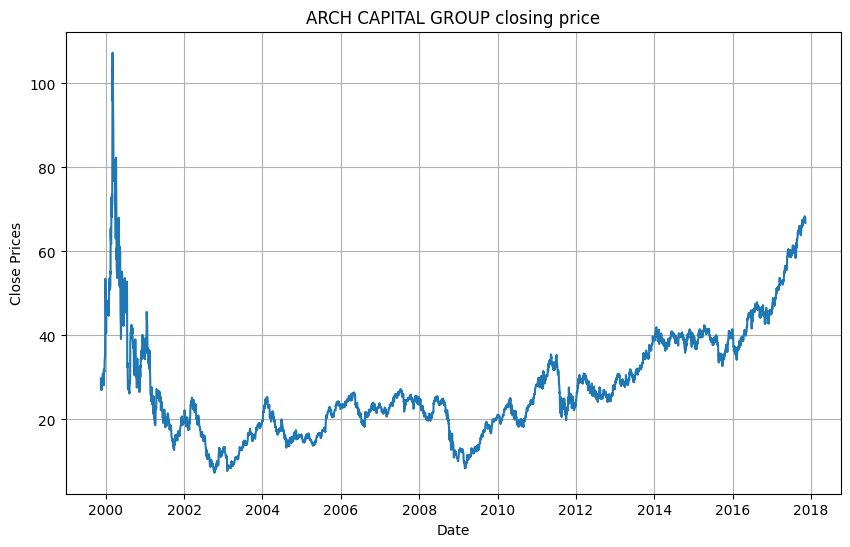

In [3]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

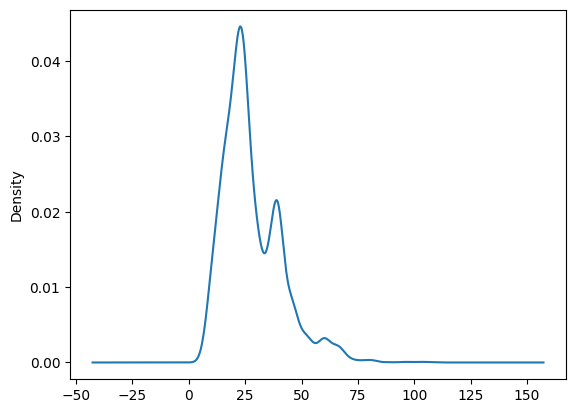

In [4]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

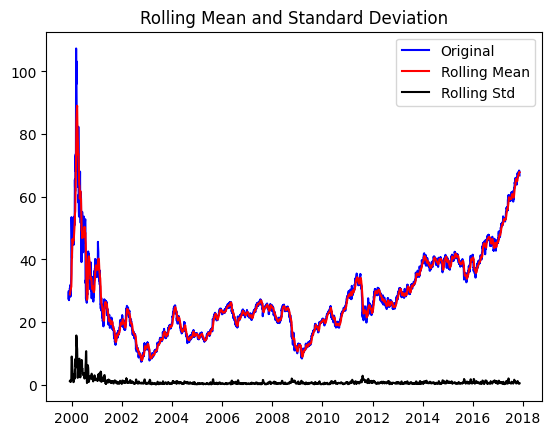

Results of dickey fuller test
Test Statistics                  -1.208904
p-value                           0.669754
No. of lags used                 32.000000
Number of observations used    4488.000000
critical value (1%)              -3.431808
critical value (5%)              -2.862184
critical value (10%)             -2.567113
dtype: float64


In [5]:

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

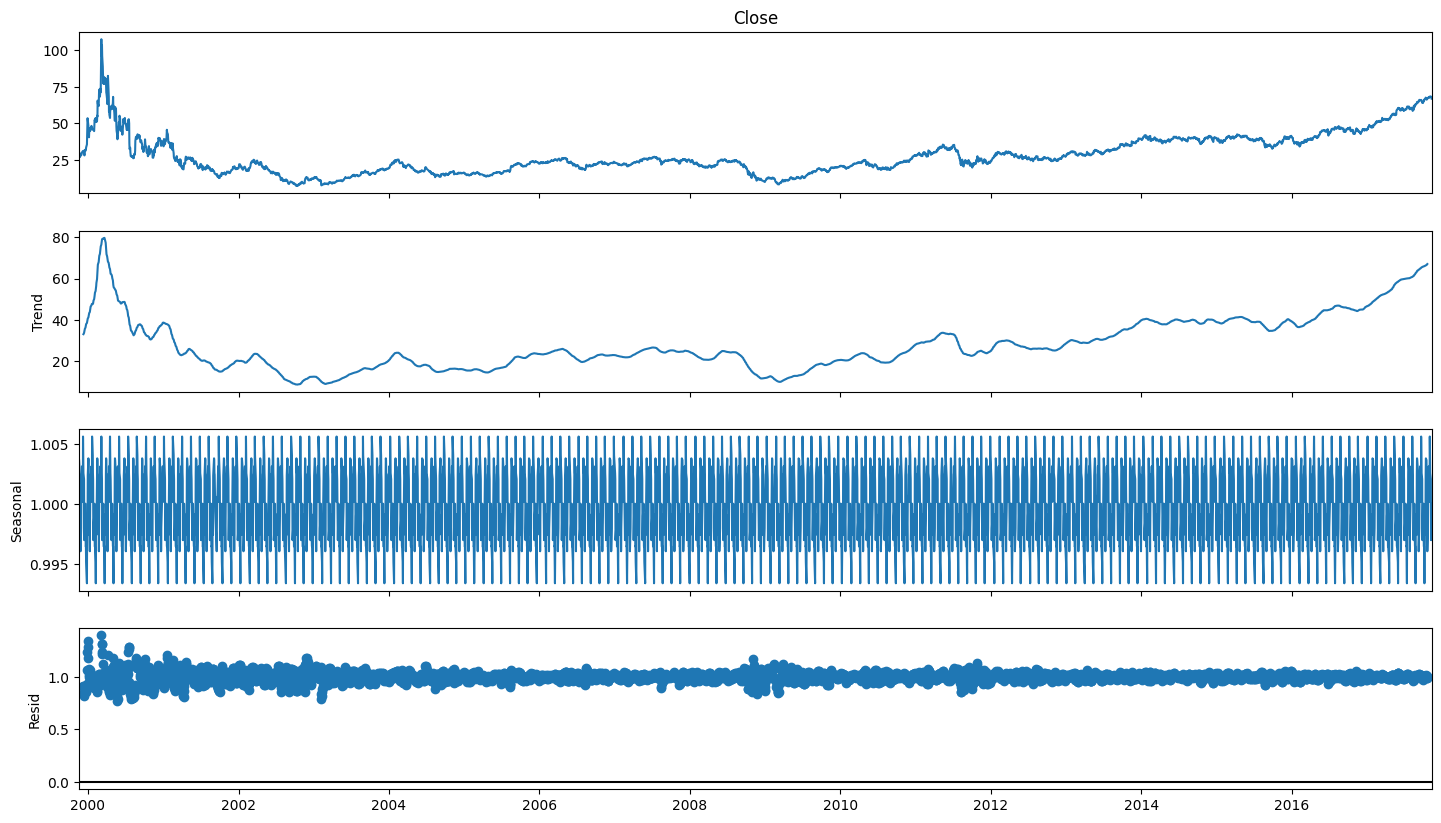

In [9]:
result = seasonal_decompose(df_close, model='multiplicative',period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

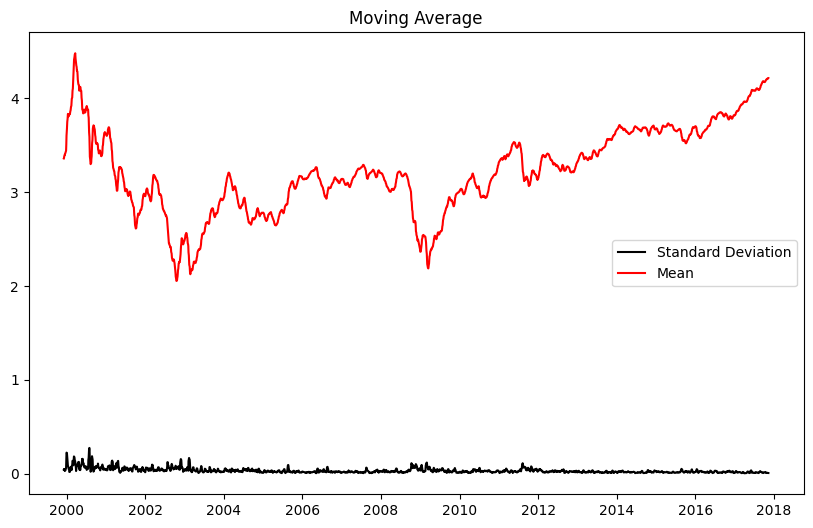

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

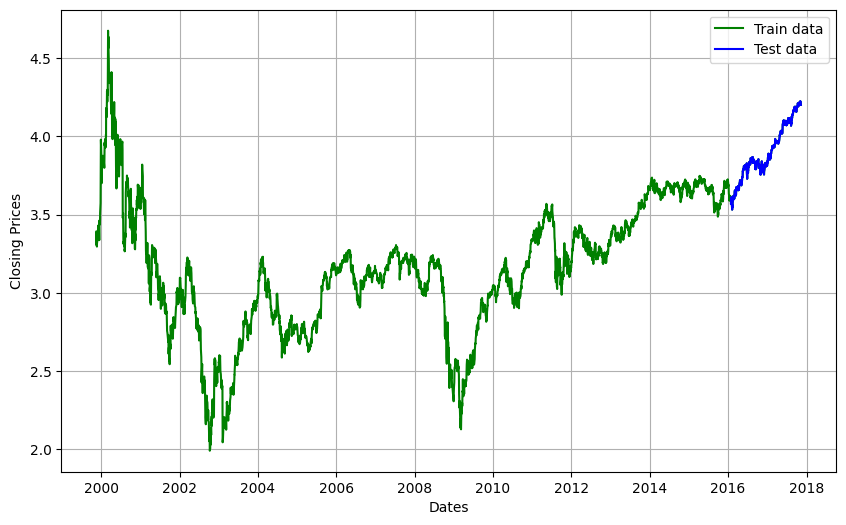

In [11]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17097.166, Time=1.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17100.558, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17100.774, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17099.141, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17106.011, Time=2.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-17098.099, Time=2.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-17100.677, Time=6.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17100.411, Time=2.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17100.029, Time=1.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-17104.157, Time=10.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-17107.701, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-17102.750, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-17102.535, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-17100.075, Time=1.44 sec
 ARI

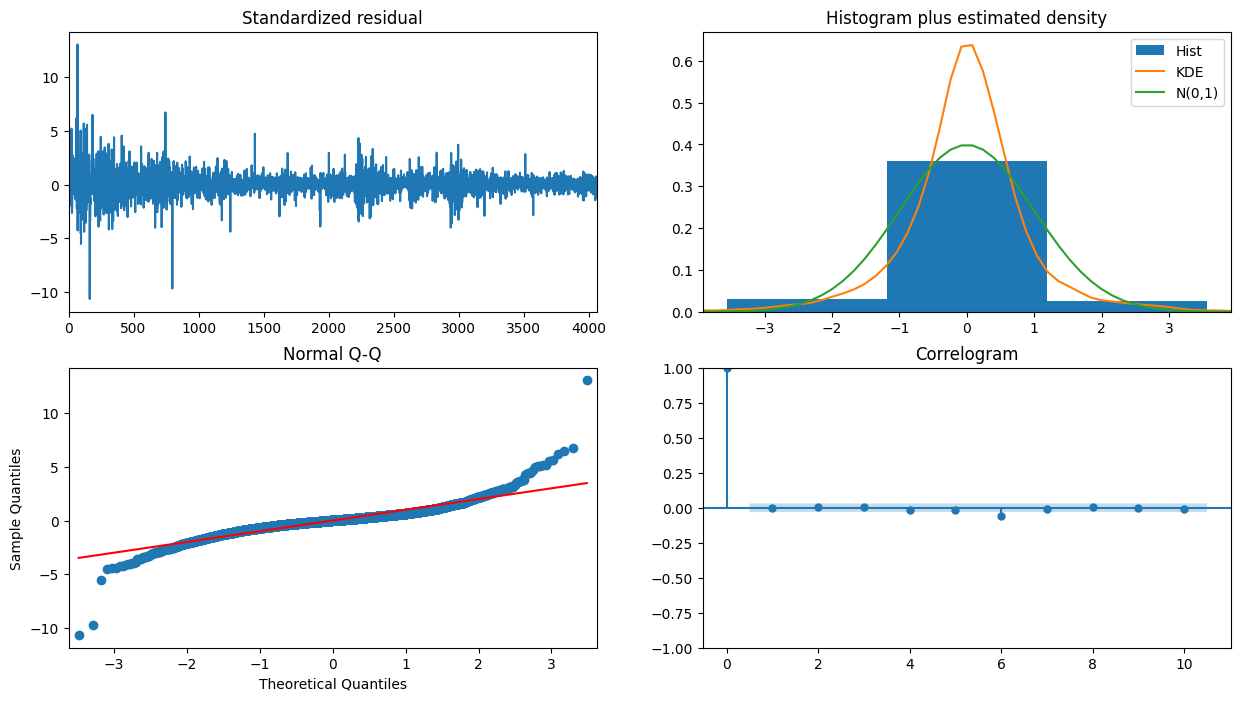

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [17]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4065
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8555.326
Date:                Fri, 10 Nov 2023   AIC                         -17102.653
Time:                        04:58:40   BIC                         -17077.413
Sample:                             0   HQIC                        -17093.713
                               - 4065                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3532      0.273     -1.296      0.195      -0.887       0.181
ma.L1          0.3923      0.273      1.438      0.150      -0.142       0.927
ma.L2         -0.0155      0.016     -0.942      0.3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


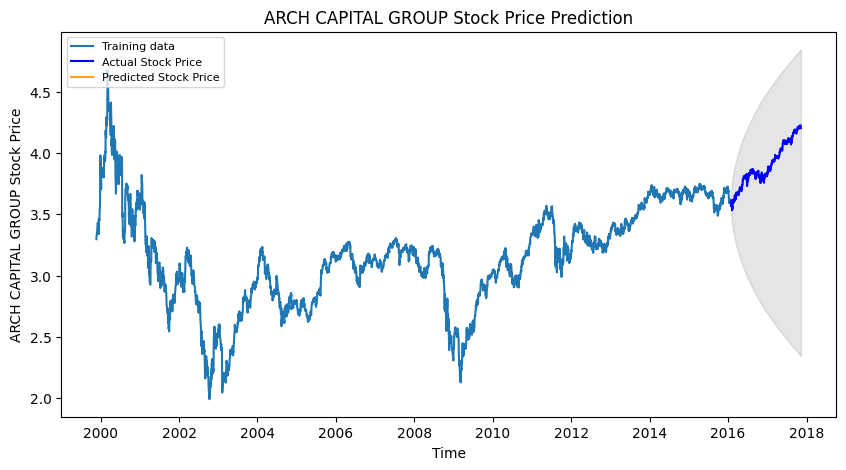

In [23]:
forecast_values = fitted.forecast(steps=321, alpha=0.05) 
fc_series = pd.Series(forecast_values, index=test_data.index)
confidence_interval = fitted.get_forecast(steps=453, alpha=0.05).conf_int()
lower_series = pd.Series(confidence_interval.iloc[:, 0].values, index=test_data.index)
upper_series = pd.Series(confidence_interval.iloc[:, 1].values, index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
